# Predicting transcription factor-DNA binding from sequence

## Changes
Convolving 26 PWMs together
& increased no. of parameters

### Setup

In [1]:
!pip install bio

     |████████████████████████████████| 272 kB 13.2 MB/s 
     |████████████████████████████████| 2.3 MB 37.7 MB/s 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module, Linear, ReLU, Sequential, Conv2d, Conv1d, MaxPool1d, MaxPool2d, BatchNorm1d, BatchNorm2d, Dropout
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import os
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm, trange
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder, normalize
import matplotlib.pyplot as plt
from Bio import SeqIO

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


##Data Path

In [5]:
data_path = "drive/My Drive/CS582-Project/Datasets/topic1-data/"
batch_size = 100
validation_ratio = 0.2

### Reading Transcription Factors

In [6]:
def get_tf_list(data_path):
  tf_list = os.listdir(data_path)
  for tf in tf_list:
      if not os.path.isdir(data_path+tf):
          tf_list.remove(tf)
  return tf_list

### Preprocessing & Reading Data

In [7]:
def one_hot_encoder(sequence):
   encoder = OneHotEncoder(sparse=False, dtype=int, handle_unknown='ignore')
   encoder.fit([['A'], ['T'], ['C'], ['G']])
   onehot_encoded = encoder.transform(sequence)
   return onehot_encoded

In [8]:
def get_data(data_path, tf_list, data_type): # type = "train"/"test"
  dataset = []
  for i in range(len(tf_list)):
    tf = tf_list[i]
    #print('=========== ', tf, ' ===========')
    sequence_path = data_path + '/' + tf + '/' + tf + '-' + data_type + '-sequence.fa'
    binding_path = data_path + '/' + tf + '/' + tf + '-' + data_type + '.bed'
    sequence = pd.DataFrame(np.array([list(record.seq.__str__().upper())
                  for record in SeqIO.parse(sequence_path, "fasta")]))
    binding = pd.read_csv(binding_path, sep='\t', header=None, names=['desc', tf]).drop(labels='desc', axis=1)
    data = pd.concat([sequence, binding], axis=1)
    dataset.append(data)
  seq_len = len(dataset[0].columns) - 1
  #print(seq_len)
  dataset = pd.concat(dataset, axis=1, join="inner")
  dataset = dataset.loc[:,~dataset.columns.duplicated()]
  dataset = dataset.sample(frac=1).reset_index(drop=True)
  dataset.to_csv('dataset.csv')
  sequence = dataset.iloc[:, 0:seq_len]
  binding = dataset.iloc[:, seq_len:]
  #print(sequence.shape)
  #print(binding.shape)
  #sequence = dataset.iloc[:, 0:seq_len]
  sequence = sequence.to_numpy()
  sequence = sequence.reshape(sequence.shape[0], -1, 1)
  #print(sequence[0])
  sequence = np.array([one_hot_encoder(row) for row in sequence], dtype='float32')
  binding = ((binding / binding.max(axis=0)).to_numpy())
  
  #binding = np.log2(binding + 0.5)
  #print(binding)
  #print(sequence.shape)
  #print(sequence[0])
  #print(atcg_ratio)
  return {'seq': sequence, 'chip': binding}

In [9]:
def get_symbol_ratio(sequence):
  seq_shape = sequence.shape
  atcg_ratio = np.sum(np.sum(sequence, axis=1), axis=0)/(seq_shape[0] * seq_shape[1])
  return atcg_ratio

In [10]:
def get_pwm_list(data_path, tf_list, file_ext, non_site_prob):
  pwm_files = [data_path + '/' + tf + '/' + tf + file_ext for tf in tf_list]
  tf_cnt = len(tf_list)
  #print(pwm_files)
  pwm_list = [normalize(pd.read_csv(pwm_file, names = ['A', 'C', 'G', 'T'], sep="\t", header=None,
                          skiprows=1, skipfooter=1, dtype='float32', engine='python')
                          .to_numpy(), axis=1, norm='l1')
                          for pwm_file in pwm_files]
  #print(pwm_list)
  length = np.array([pwm.shape[0] for pwm in pwm_list])
  max_length = length.max()
  append = max_length - length
  append_up = append // 2
  append_down = append - append_up
  arr_up = np.array([np.repeat([non_site_prob], append_up[i], axis=0) for i in range(tf_cnt)])
  arr_down = np.array([np.repeat([non_site_prob], append_down[i], axis=0) for i in range(tf_cnt)])
  pwm_list = np.array([np.concatenate((arr_up[i], pwm_list[i], arr_down[i]), axis=0)
                      .reshape(1, max_length, 4).astype('float32')
                      for i in range(tf_cnt)])
  #print('pwm_list', pwm_list)
  #print('shape ', pwm_list.shape)
  return pwm_list

##Custom Dataset

In [11]:
class TFBindingDataset(Dataset):
    def __init__(self, data):
        super(TFBindingDataset, self).__init__()
        self.X = torch.from_numpy(data['seq'])
        shape = self.X.shape
        self.X = self.X.reshape(shape[0], 1, shape[1], shape[2])
        self.y = torch.from_numpy(data['chip'])

    def __getitem__(self, index):
        if torch.is_tensor(index):
           index = index.tolist()
        return self.X[index], self.y[index] 

    def __len__(self):
        return self.X.shape[0]

### Binding Score

In [12]:
def get_binding_values(data_loaders, tf_list):
    binding_dict = {}
    for i in range(len(tf_list)):
      binding_values = []
      for data_loader in data_loaders:
        for data in data_loader:
            _, y = data
            y = y[:, i]
            binding_values.extend(torch.reshape(y, (-1,)))
      binding_values = torch.stack(binding_values)
      binding_dict[tf_list[i]] = binding_values
    return binding_dict

### Model

In [13]:
class BindingPredictionCNN(Module):
    def __init__(self, weight):
        super().__init__()
        self.conv1 = Conv2d(in_channels=1, out_channels=26, kernel_size=(30, 4), stride=1)
        with torch.no_grad():
            self.conv1.weight = nn.Parameter(weight)
        self.conv2 = Conv2d(in_channels=1, out_channels=25, kernel_size=(26, 1), stride=1)
        self.conv3 = Conv1d(in_channels=25, out_channels=50, kernel_size=12, stride=1)
        self.drop1 = nn.Dropout(0.1)
        self.drop2 = nn.Dropout(0.2)

        self.fc1 = Linear(in_features=1750, out_features=1000)
        self.fc2 = Linear(in_features=1000, out_features=500)
        self.out = Linear(in_features=500, out_features=26)

    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.conv1(x)).squeeze()
        #print(x.shape)
        x = F.max_pool1d(x, 10, 5)
        #print(x.shape)
        shape = x.shape
        x = x.reshape(shape[0], 1, shape[1], shape[2])
        x = (F.relu(self.conv2(x))).squeeze()

        #print(x.shape)
        x = F.max_pool1d(x, 2, 2)
        #print(x.shape)

        x = F.relu(self.conv3(x))
        #print(x.shape)
      
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = self.drop2(x)
        x = self.out(x)
        return x

##Plots

In [14]:
def plot_binding_histogram(data_loaders, tf_list):
    binding_dict = get_binding_values(data_loaders, tf_list)
    #print(len(binding_dict))
    for tf in tf_list:
      #print(tf)
      binding_values = binding_dict[tf]
      #print(binding_values)
      plt.figure(figsize=(7,7))
      plt.title(tf + " Bindings Histogram")
      plt.xlabel("Binding Value")
      plt.ylabel("Count")
      plt.hist(binding_values, bins=40)

In [15]:
def classification_statistics(y_true_binary, y_pred_binary):
    tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * tp / (2 * tp + fp + fn)

    print(confusion_matrix(y_true_binary, y_pred_binary))
    print(classification_report(y_true_binary, y_pred_binary))
    print("=== Statistics ===")
    print("Test Accuracy: %.3f" % accuracy)
    print("Test Sensitivity: %.3f" % sensitivity)
    print("Test Specificity: %.3f" % specificity)
    print("Test F1-Score: %.3f" % f1_score)
    return {'accuracy': accuracy, 'sensitivity': sensitivity, 'specificity': specificity, 'f1score': f1_score}

In [16]:
def plot_loss(train_log, train_log1, val_log, epoch_num):
    plt.figure(figsize=(7,7))
    plt.plot(range(1, epoch_num + 1), train_log, color='C0', label='training')
    plt.plot(range(1, epoch_num + 1), train_log1, color='C2', label='training1')
    plt.plot(range(1, epoch_num + 1), val_log, color='C1', label='validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('MSE Loss')
    plt.legend(loc='best')
    plt.savefig('fig.pdf')
    plt.show()

In [17]:
def roc_auc_curve_plot(y_true_binary, y_pred_binary, tf):
  fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary)
  auc = roc_auc_score(y_true_binary, y_pred_binary)
  plt.figure(figsize=(7,7))
  plt.plot(fpr, tpr, label="auc="+str(auc))
  plt.title('ROC-AUC for Classification Task - ' + tf)
  plt.xlabel('1 - Specificity')
  plt.ylabel('Sensitivity')
  plt.legend(loc='best')
  plt.legend()
  plt.show()

##Training

In [18]:
def train(net, train_loader, val_loader, optimizer, criterion, device, epoch_num):
    train_log = []
    val_log = []
    train_log1 = []
    lambda1 = 0.00005
    lambda2 = 0.000005

    for epoch in range(1, epoch_num+1):
        train_loss = []
        net.train()
        for (x, y) in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = net(x)
            #print(outputs)
            #print(y)
            loss = criterion(outputs.float(), y.float())
            """
            params = []
            for param in net.parameters():
              params.append(param.view(-1))
            params = torch.cat(params)
            l1_loss = lambda1 * torch.abs(params).sum()
            l2_loss = lambda2 * torch.square(params).sum()
            loss += l1_loss + l2_loss"""
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_log.append(np.mean(train_loss))
        print('============ epoch %d =============' %epoch)
        print('train loss: %.3f' % np.mean(train_loss), flush=True, end='')
        
        train_loss1 = []
        net.eval()
        with torch.no_grad():
            for (x, y) in tqdm(train_loader, desc='Train1 ', leave=False):
                x, y = x.to(device), y.to(device)
                outputs = net(x)
                loss = criterion(outputs.float(), y.float())
                train_loss1.append(loss.item())
        train_log1.append(np.mean(train_loss1))
        print('train1 loss: %.3f' % np.mean(train_loss1), flush=True, end='')

        test_loss = []
        #net.eval()
        with torch.no_grad():
            for (x, y) in tqdm(val_loader, desc='Validation ', leave=False):
                x, y = x.to(device), y.to(device)
                outputs = net(x)
                loss = criterion(outputs.float(), y.float())
                test_loss.append(loss.item())
        val_log.append(np.mean(test_loss))
        print('validation loss: %.3f' % np.mean(test_loss), flush=True, end='')
    return train_log, train_log1, val_log

##Train Evaluation

In [19]:
tf_list = get_tf_list(data_path)

In [20]:
train_data = get_data(data_path, tf_list, "train")
train_set = TFBindingDataset(train_data)
atcg_ratio = get_symbol_ratio(train_data['seq'])
weight = torch.from_numpy(get_pwm_list(data_path, tf_list, "_GM12878_4.wtmx", atcg_ratio))
 
train_set, val_set = random_split(train_set, [int(len(train_set)) - int(len(train_set)*validation_ratio), int(len(train_set)*validation_ratio)])    

train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(dataset=val_set,
                          batch_size=batch_size,
                          shuffle=True)
model = BindingPredictionCNN(weight)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
print(model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


BindingPredictionCNN(
  (conv1): Conv2d(1, 26, kernel_size=(30, 4), stride=(1, 1))
  (conv2): Conv2d(1, 25, kernel_size=(26, 1), stride=(1, 1))
  (conv3): Conv1d(25, 50, kernel_size=(12,), stride=(1,))
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1750, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (out): Linear(in_features=500, out_features=26, bias=True)
)


In [21]:
epoch_count = 250

In [22]:
train_log, train_log1, val_log = train(model, train_loader, val_loader, optimizer, criterion, device, epoch_count)


Training epoch 1:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 1 =============
train loss: 0.020

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.011

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 2:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 2 =============
train loss: 0.013

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.011

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 3:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 3 =============
train loss: 0.011

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.009

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 4:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 4 =============
train loss: 0.011

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.009

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 5:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 5 =============
train loss: 0.010

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.009

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 6:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 6 =============
train loss: 0.010

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.009

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 7:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 7 =============
train loss: 0.010

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.009

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 8:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 8 =============
train loss: 0.010

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.009

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 9:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 9 =============
train loss: 0.009

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 10:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 10 =============
train loss: 0.009

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 11:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 11 =============
train loss: 0.009

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 12:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 12 =============
train loss: 0.009

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 13:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 13 =============
train loss: 0.009

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 14:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 14 =============
train loss: 0.009

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 15:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 15 =============
train loss: 0.009

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 16:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 16 =============
train loss: 0.009

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 17:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 17 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 18:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 18 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 19:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 19 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 20:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 20 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 21:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 21 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 22:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 22 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 23:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 23 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 24:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 24 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 25:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 25 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 26:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 26 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 27:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 27 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 28:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 28 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 29:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 29 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 30:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 30 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 31:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 31 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 32:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 32 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 33:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 33 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 34:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 34 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 35:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 35 =============
train loss: 0.008

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 36:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 36 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 37:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 37 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 38:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 38 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 39:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 39 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 40:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 40 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.008

Training epoch 41:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 41 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 42:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 42 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 43:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 43 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 44:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 44 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 45:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 45 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 46:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 46 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 47:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 47 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 48:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 48 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 49:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 49 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 50:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 50 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 51:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 51 =============
train loss: 0.007

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 52:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 52 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 53:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 53 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 54:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 54 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 55:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 55 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 56:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 56 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 57:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 57 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 58:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 58 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 59:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 59 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 60:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 60 =============
train loss: 0.006

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 61:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 61 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 62:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 62 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 63:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 63 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 64:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 64 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 65:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 65 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 66:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 66 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 67:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 67 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 68:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 68 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 69:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 69 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 70:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 70 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 71:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 71 =============
train loss: 0.005

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 72:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 72 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 73:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 73 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 74:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 74 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 75:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 75 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 76:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 76 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 77:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 77 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 78:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 78 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 79:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 79 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 80:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 80 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 81:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 81 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 82:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 82 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 83:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 83 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 84:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 84 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 85:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 85 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 86:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 86 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 87:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 87 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 88:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 88 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 89:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 89 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 90:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 90 =============
train loss: 0.004

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 91:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 91 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 92:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 92 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 93:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 93 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.009

Training epoch 94:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 94 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 95:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 95 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 96:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 96 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 97:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 97 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 98:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 98 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 99:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 99 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 100:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 100 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 101:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 101 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 102:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 102 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 103:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 103 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 104:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 104 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 105:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 105 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 106:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 106 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 107:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 107 =============
train loss: 0.003

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 108:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 108 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 109:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 109 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 110:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 110 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 111:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 111 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 112:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 112 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 113:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 113 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 114:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 114 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 115:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 115 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 116:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 116 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 117:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 117 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 118:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 118 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 119:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 119 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 120:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 120 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 121:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 121 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 122:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 122 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 123:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 123 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 124:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 124 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 125:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 125 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 126:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 126 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 127:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 127 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 128:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 128 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 129:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 129 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 130:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 130 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 131:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 131 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 132:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 132 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 133:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 133 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 134:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 134 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 135:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 135 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 136:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 136 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 137:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 137 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 138:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 138 =============
train loss: 0.002

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 139:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 139 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 140:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 140 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 141:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 141 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 142:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 142 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 143:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 143 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 144:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 144 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 145:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 145 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 146:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 146 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 147:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 147 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 148:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 148 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 149:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 149 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 150:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 150 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 151:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 151 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 152:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 152 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 153:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 153 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 154:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 154 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 155:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 155 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 156:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 156 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 157:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 157 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 158:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 158 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 159:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 159 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 160:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 160 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 161:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 161 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 162:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 162 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 163:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 163 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 164:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 164 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 165:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 165 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 166:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 166 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 167:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 167 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 168:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 168 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 169:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 169 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 170:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 170 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 171:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 171 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 172:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 172 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 173:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 173 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 174:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 174 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 175:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 175 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 176:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 176 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 177:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 177 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 178:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 178 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 179:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 179 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 180:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 180 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 181:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 181 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 182:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 182 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 183:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 183 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 184:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 184 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 185:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 185 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 186:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 186 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 187:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 187 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 188:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 188 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 189:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 189 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 190:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 190 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 191:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 191 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 192:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 192 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 193:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 193 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 194:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 194 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 195:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 195 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 196:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 196 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 197:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 197 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 198:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 198 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 199:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 199 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 200:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 200 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 201:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 201 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 202:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 202 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 203:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 203 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 204:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 204 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 205:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 205 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 206:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 206 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 207:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 207 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 208:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 208 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 209:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 209 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 210:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 210 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 211:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 211 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 212:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 212 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 213:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 213 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 214:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 214 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 215:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 215 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 216:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 216 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 217:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 217 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 218:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 218 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 219:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 219 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 220:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 220 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 221:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 221 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 222:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 222 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 223:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 223 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 224:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 224 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 225:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 225 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 226:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 226 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 227:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 227 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 228:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 228 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 229:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 229 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 230:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 230 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 231:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 231 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 232:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 232 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 233:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 233 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 234:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 234 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 235:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 235 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 236:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 236 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 237:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 237 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 238:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 238 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 239:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 239 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 240:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 240 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 241:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 241 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 242:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 242 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 243:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 243 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 244:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 244 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.011

Training epoch 245:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 245 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 246:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 246 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 247:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 247 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 248:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 248 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 249:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 249 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

Training epoch 250:   0%|          | 0/7 [00:00<?, ?it/s]

============ epoch 250 =============
train loss: 0.001

Train1 :   0%|          | 0/7 [00:00<?, ?it/s]

train1 loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.010

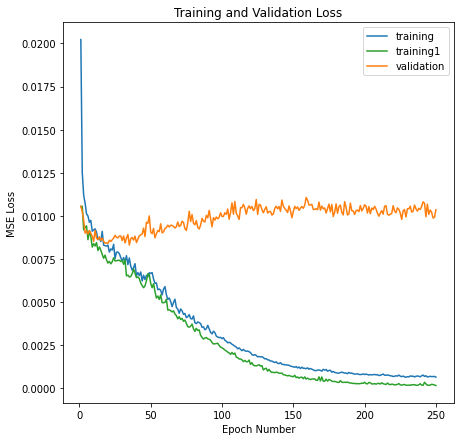

In [32]:
plot_loss(train_log, train_log1, val_log, epoch_count)

In [33]:
torch.save(model.state_dict(), 'drive/My Drive/CS582-Project/Models/model-11-file')

##Testing

In [34]:
def test(net, test_loader, device):
    y_true = []
    y_pred = []
    net.eval()
    with torch.no_grad():
        for (x_input,labels) in tqdm(test_loader, desc='Test ', leave=False):
            x_input, labels = x_input.to(device), labels.to(device)
            outputs = net(x_input)
            y_true.extend(labels.float().detach().cpu().numpy())
            y_pred.extend(outputs.float().detach().cpu().numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return y_true, y_pred

##Test Evaluation

In [35]:
test_data = get_data(data_path, tf_list, "test")
test_set = TFBindingDataset(test_data)
test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                        shuffle=True)
y_true, y_pred = test(model, test_loader, device)

Test :   0%|          | 0/4 [00:00<?, ?it/s]

In [36]:
print("Test MSE: ", mean_squared_error(y_true, y_pred))

Test MSE:  0.017617505


### Classification

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


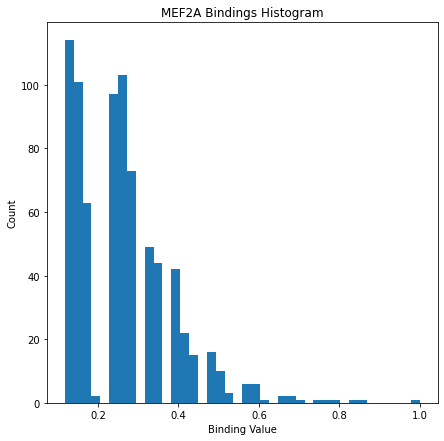

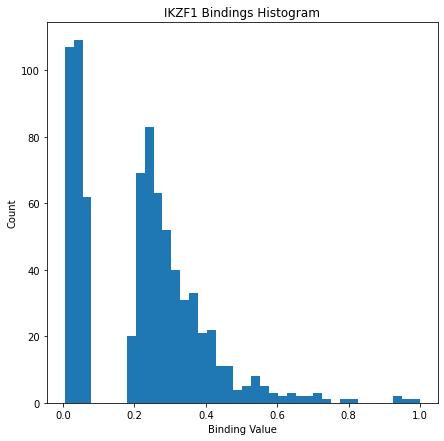

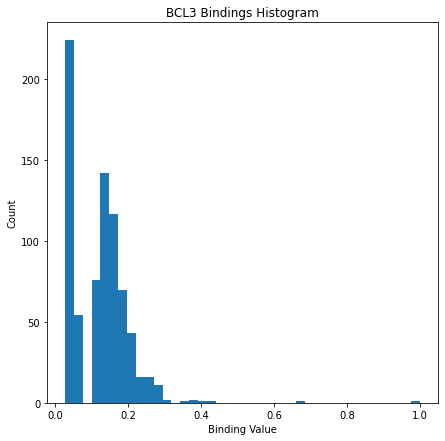

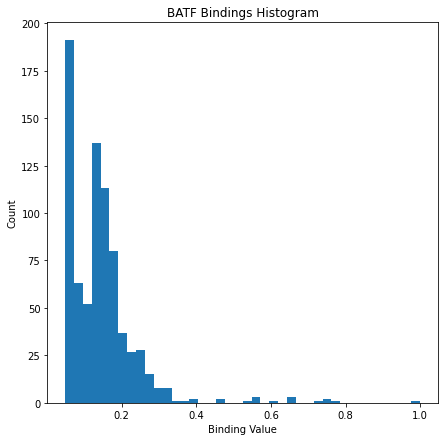

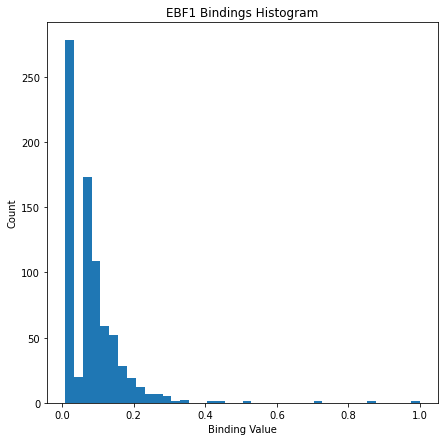

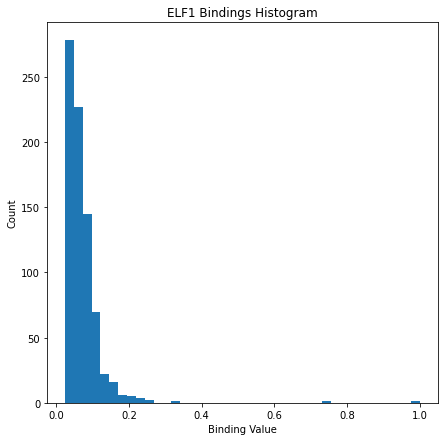

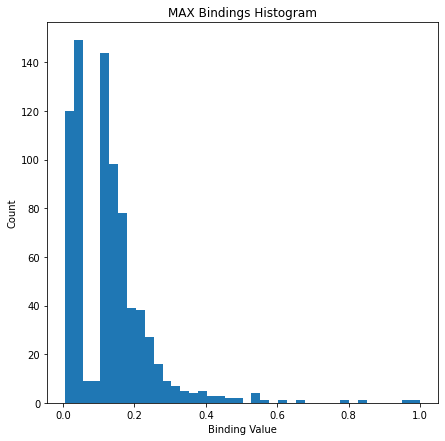

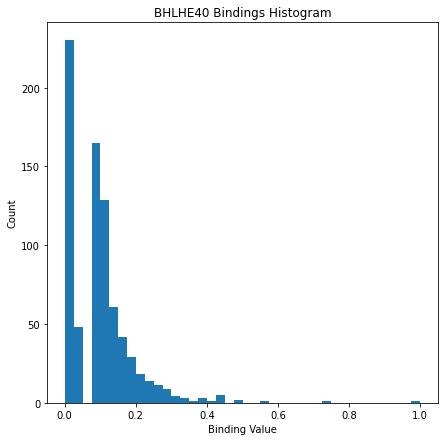

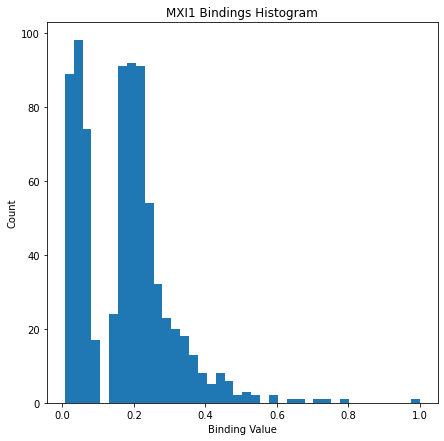

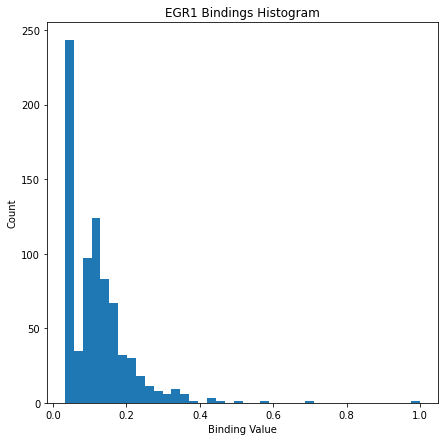

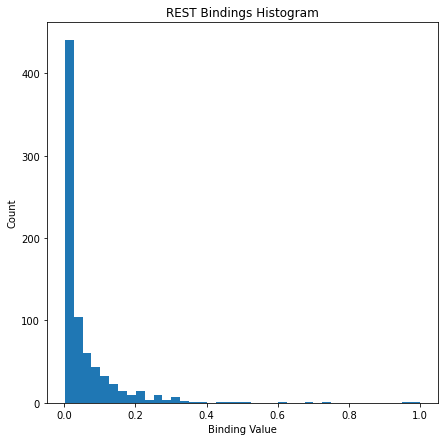

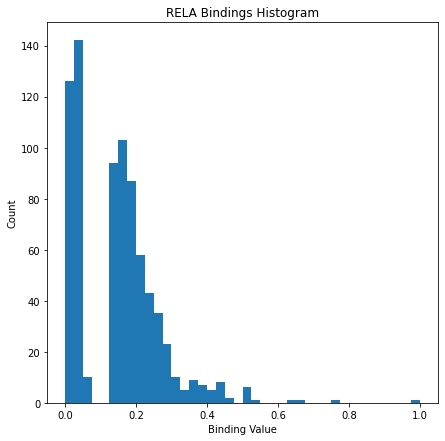

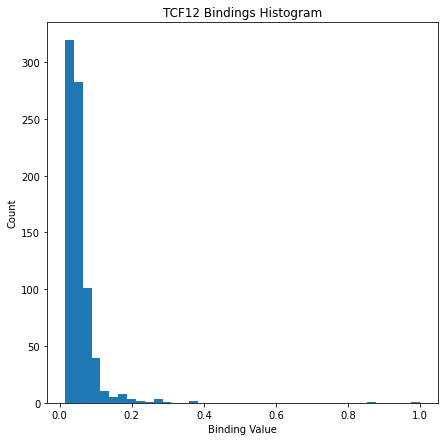

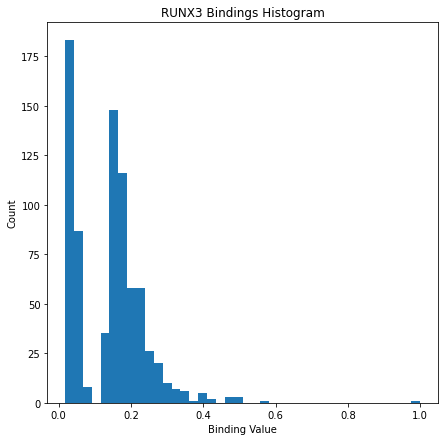

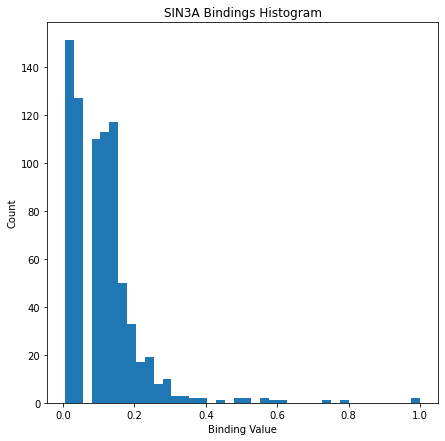

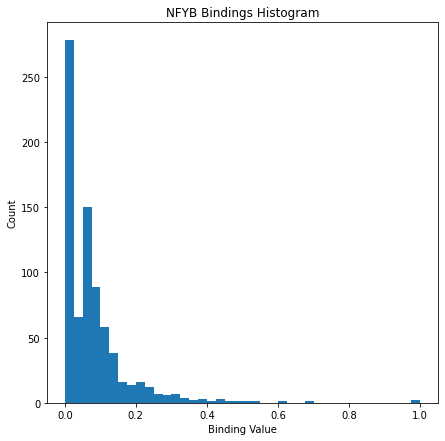

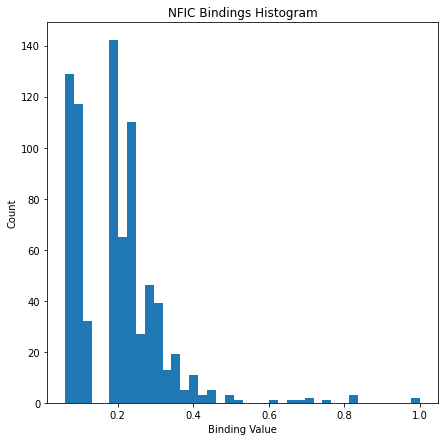

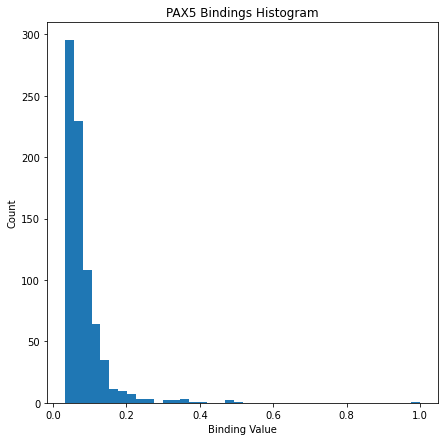

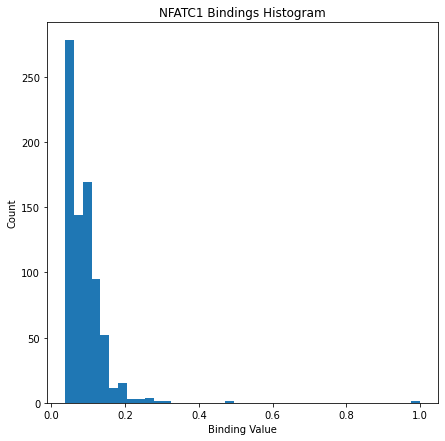

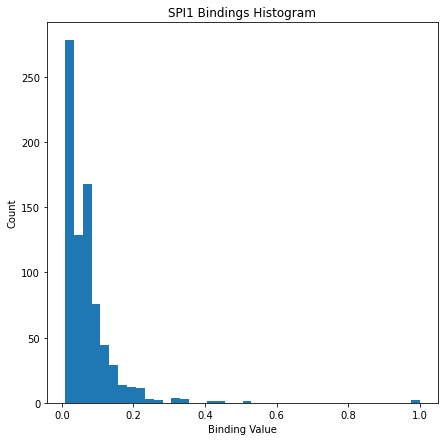

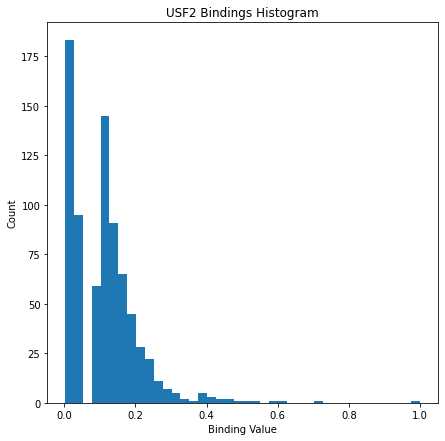

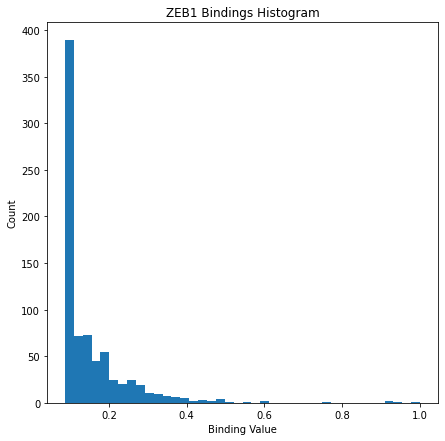

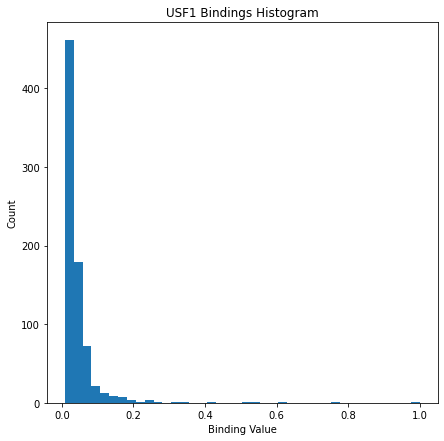

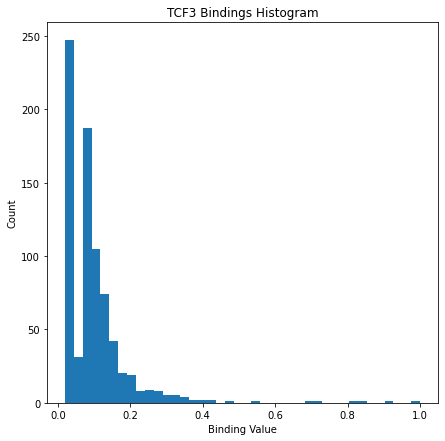

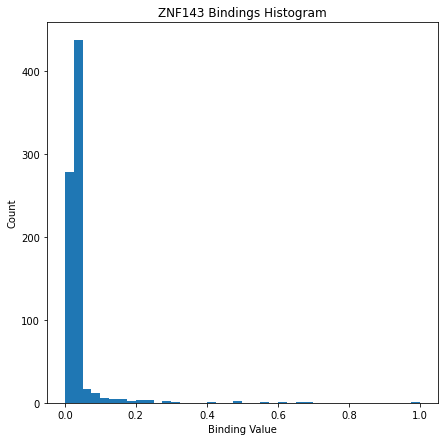

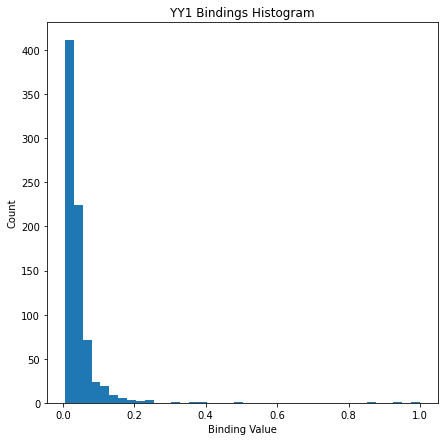

In [37]:
plot_binding_histogram([train_loader, val_loader], tf_list)

In [38]:
binding_dict = get_binding_values([train_loader, val_loader], tf_list)
#for (key, value) in binding_dict.items():
#  print(len(value))

In [39]:
print(y_true.shape)
print(y_pred.shape)

(400, 26)
(400, 26)


================  MEF2A  ================
0.26273979911906514
[[195  73]
 [ 65  67]]
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       268
           1       0.48      0.51      0.49       132

    accuracy                           0.66       400
   macro avg       0.61      0.62      0.62       400
weighted avg       0.66      0.66      0.66       400

=== Statistics ===
Test Accuracy: 0.655
Test Sensitivity: 0.508
Test Specificity: 0.728
Test F1-Score: 0.493
<class 'dict'>
{'accuracy': 0.655, 'sensitivity': 0.5075757575757576, 'specificity': 0.7276119402985075, 'f1score': 0.49264705882352944}


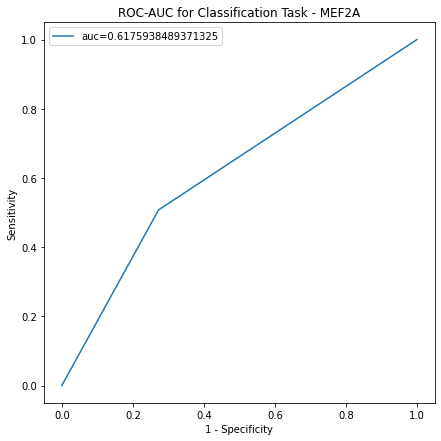

================  IKZF1  ================
0.22016896823448862
[[150 100]
 [ 88  62]]
              precision    recall  f1-score   support

           0       0.63      0.60      0.61       250
           1       0.38      0.41      0.40       150

    accuracy                           0.53       400
   macro avg       0.51      0.51      0.51       400
weighted avg       0.54      0.53      0.53       400

=== Statistics ===
Test Accuracy: 0.530
Test Sensitivity: 0.413
Test Specificity: 0.600
Test F1-Score: 0.397
<class 'dict'>
{'accuracy': 0.53, 'sensitivity': 0.41333333333333333, 'specificity': 0.6, 'f1score': 0.3974358974358974}


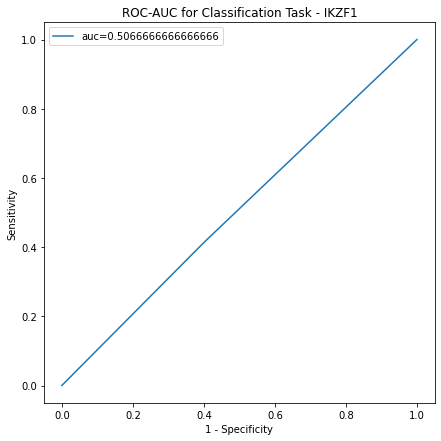

================  BCL3  ================
0.12074754422425077
[[145  69]
 [117  69]]
              precision    recall  f1-score   support

           0       0.55      0.68      0.61       214
           1       0.50      0.37      0.43       186

    accuracy                           0.54       400
   macro avg       0.53      0.52      0.52       400
weighted avg       0.53      0.54      0.52       400

=== Statistics ===
Test Accuracy: 0.535
Test Sensitivity: 0.371
Test Specificity: 0.678
Test F1-Score: 0.426
<class 'dict'>
{'accuracy': 0.535, 'sensitivity': 0.3709677419354839, 'specificity': 0.677570093457944, 'f1score': 0.42592592592592593}


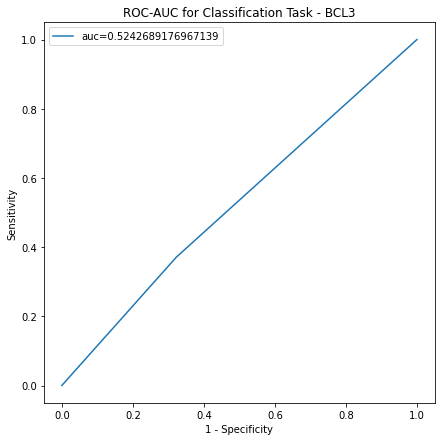

================  BATF  ================
0.14156077590307864
[[201 112]
 [ 60  27]]
              precision    recall  f1-score   support

           0       0.77      0.64      0.70       313
           1       0.19      0.31      0.24        87

    accuracy                           0.57       400
   macro avg       0.48      0.48      0.47       400
weighted avg       0.64      0.57      0.60       400

=== Statistics ===
Test Accuracy: 0.570
Test Sensitivity: 0.310
Test Specificity: 0.642
Test F1-Score: 0.239
<class 'dict'>
{'accuracy': 0.57, 'sensitivity': 0.3103448275862069, 'specificity': 0.6421725239616614, 'f1score': 0.23893805309734514}


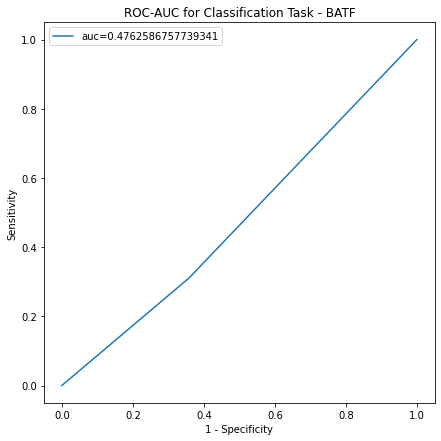

================  EBF1  ================
0.07934129723797231
[[199 102]
 [ 73  26]]
              precision    recall  f1-score   support

           0       0.73      0.66      0.69       301
           1       0.20      0.26      0.23        99

    accuracy                           0.56       400
   macro avg       0.47      0.46      0.46       400
weighted avg       0.60      0.56      0.58       400

=== Statistics ===
Test Accuracy: 0.562
Test Sensitivity: 0.263
Test Specificity: 0.661
Test F1-Score: 0.229
<class 'dict'>
{'accuracy': 0.5625, 'sensitivity': 0.26262626262626265, 'specificity': 0.6611295681063123, 'f1score': 0.2290748898678414}


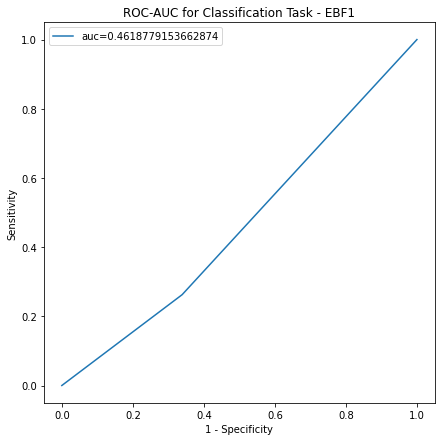

================  ELF1  ================
0.07190101946351779
[[ 59  41]
 [186 114]]
              precision    recall  f1-score   support

           0       0.24      0.59      0.34       100
           1       0.74      0.38      0.50       300

    accuracy                           0.43       400
   macro avg       0.49      0.48      0.42       400
weighted avg       0.61      0.43      0.46       400

=== Statistics ===
Test Accuracy: 0.432
Test Sensitivity: 0.380
Test Specificity: 0.590
Test F1-Score: 0.501
<class 'dict'>
{'accuracy': 0.4325, 'sensitivity': 0.38, 'specificity': 0.59, 'f1score': 0.5010989010989011}


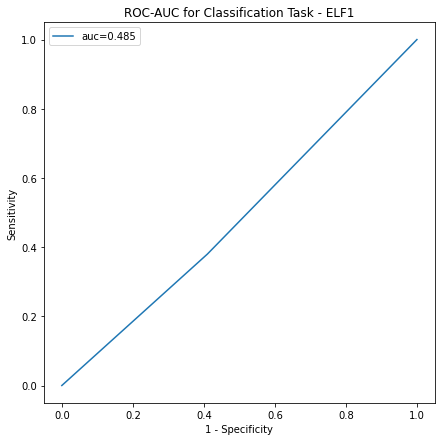

================  MAX  ================
0.12979164595435244
[[150  70]
 [117  63]]
              precision    recall  f1-score   support

           0       0.56      0.68      0.62       220
           1       0.47      0.35      0.40       180

    accuracy                           0.53       400
   macro avg       0.52      0.52      0.51       400
weighted avg       0.52      0.53      0.52       400

=== Statistics ===
Test Accuracy: 0.532
Test Sensitivity: 0.350
Test Specificity: 0.682
Test F1-Score: 0.403
<class 'dict'>
{'accuracy': 0.5325, 'sensitivity': 0.35, 'specificity': 0.6818181818181818, 'f1score': 0.402555910543131}


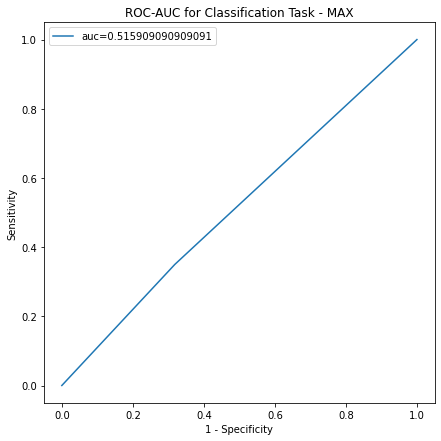

================  BHLHE40  ================
0.09841965527413712
[[148  87]
 [103  62]]
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       235
           1       0.42      0.38      0.39       165

    accuracy                           0.53       400
   macro avg       0.50      0.50      0.50       400
weighted avg       0.52      0.53      0.52       400

=== Statistics ===
Test Accuracy: 0.525
Test Sensitivity: 0.376
Test Specificity: 0.630
Test F1-Score: 0.395
<class 'dict'>
{'accuracy': 0.525, 'sensitivity': 0.37575757575757573, 'specificity': 0.6297872340425532, 'f1score': 0.39490445859872614}


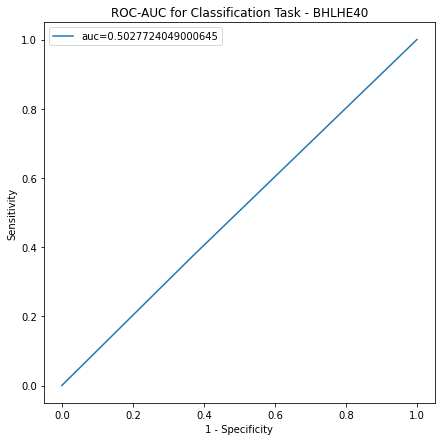

================  MXI1  ================
0.17414884945764622
[[188 105]
 [ 72  35]]
              precision    recall  f1-score   support

           0       0.72      0.64      0.68       293
           1       0.25      0.33      0.28       107

    accuracy                           0.56       400
   macro avg       0.49      0.48      0.48       400
weighted avg       0.60      0.56      0.57       400

=== Statistics ===
Test Accuracy: 0.557
Test Sensitivity: 0.327
Test Specificity: 0.642
Test F1-Score: 0.283
<class 'dict'>
{'accuracy': 0.5575, 'sensitivity': 0.32710280373831774, 'specificity': 0.6416382252559727, 'f1score': 0.2834008097165992}


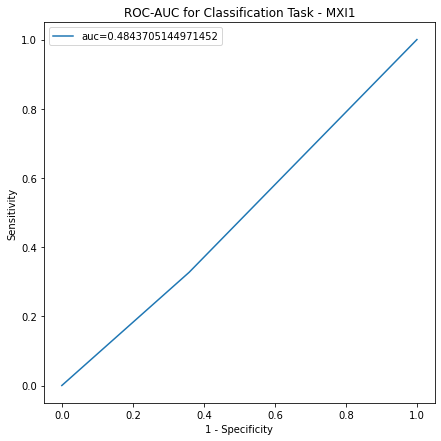

================  EGR1  ================
0.11713507111989521
[[202 132]
 [ 44  22]]
              precision    recall  f1-score   support

           0       0.82      0.60      0.70       334
           1       0.14      0.33      0.20        66

    accuracy                           0.56       400
   macro avg       0.48      0.47      0.45       400
weighted avg       0.71      0.56      0.61       400

=== Statistics ===
Test Accuracy: 0.560
Test Sensitivity: 0.333
Test Specificity: 0.605
Test F1-Score: 0.200
<class 'dict'>
{'accuracy': 0.56, 'sensitivity': 0.3333333333333333, 'specificity': 0.6047904191616766, 'f1score': 0.2}


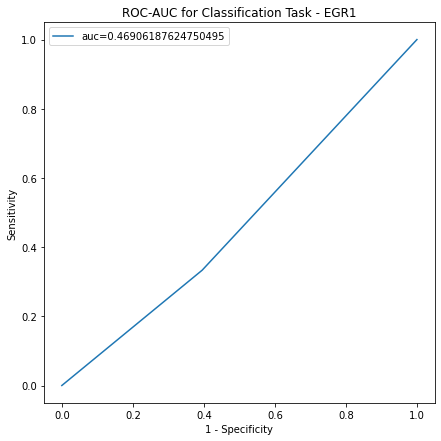

================  REST  ================
0.05350196008293021
[[226 137]
 [ 25  12]]
              precision    recall  f1-score   support

           0       0.90      0.62      0.74       363
           1       0.08      0.32      0.13        37

    accuracy                           0.59       400
   macro avg       0.49      0.47      0.43       400
weighted avg       0.82      0.59      0.68       400

=== Statistics ===
Test Accuracy: 0.595
Test Sensitivity: 0.324
Test Specificity: 0.623
Test F1-Score: 0.129
<class 'dict'>
{'accuracy': 0.595, 'sensitivity': 0.32432432432432434, 'specificity': 0.6225895316804407, 'f1score': 0.12903225806451613}


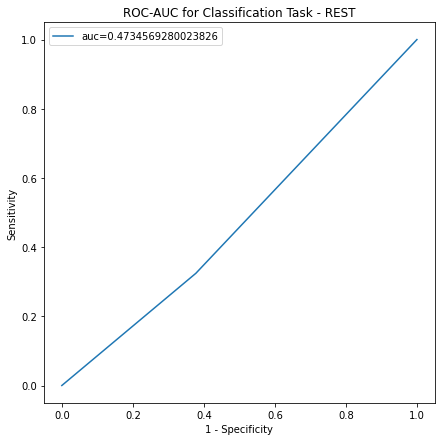

================  RELA  ================
0.1483163043715215
[[202 141]
 [ 38  19]]
              precision    recall  f1-score   support

           0       0.84      0.59      0.69       343
           1       0.12      0.33      0.18        57

    accuracy                           0.55       400
   macro avg       0.48      0.46      0.43       400
weighted avg       0.74      0.55      0.62       400

=== Statistics ===
Test Accuracy: 0.552
Test Sensitivity: 0.333
Test Specificity: 0.589
Test F1-Score: 0.175
<class 'dict'>
{'accuracy': 0.5525, 'sensitivity': 0.3333333333333333, 'specificity': 0.5889212827988338, 'f1score': 0.17511520737327188}


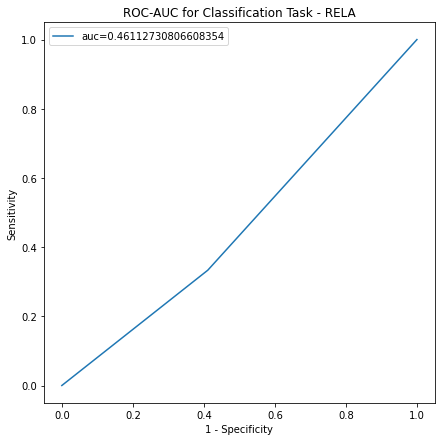

================  TCF12  ================
0.052072823373859635
[[132  57]
 [147  64]]
              precision    recall  f1-score   support

           0       0.47      0.70      0.56       189
           1       0.53      0.30      0.39       211

    accuracy                           0.49       400
   macro avg       0.50      0.50      0.47       400
weighted avg       0.50      0.49      0.47       400

=== Statistics ===
Test Accuracy: 0.490
Test Sensitivity: 0.303
Test Specificity: 0.698
Test F1-Score: 0.386
<class 'dict'>
{'accuracy': 0.49, 'sensitivity': 0.3033175355450237, 'specificity': 0.6984126984126984, 'f1score': 0.3855421686746988}


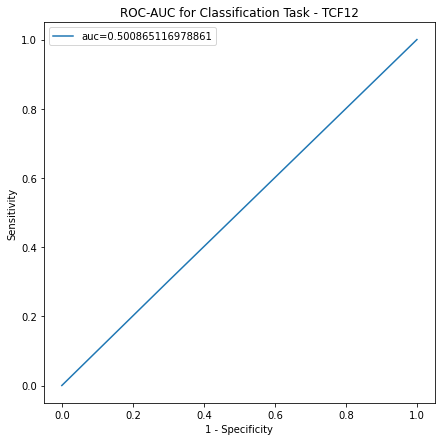

================  RUNX3  ================
0.14156101158658796
[[168 124]
 [ 80  28]]
              precision    recall  f1-score   support

           0       0.68      0.58      0.62       292
           1       0.18      0.26      0.22       108

    accuracy                           0.49       400
   macro avg       0.43      0.42      0.42       400
weighted avg       0.54      0.49      0.51       400

=== Statistics ===
Test Accuracy: 0.490
Test Sensitivity: 0.259
Test Specificity: 0.575
Test F1-Score: 0.215
<class 'dict'>
{'accuracy': 0.49, 'sensitivity': 0.25925925925925924, 'specificity': 0.5753424657534246, 'f1score': 0.2153846153846154}


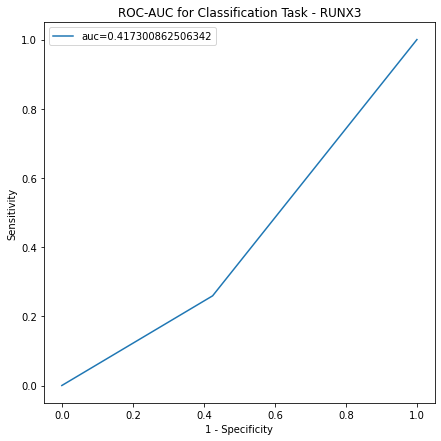

================  SIN3A  ================
0.11254525632915653
[[218 110]
 [ 45  27]]
              precision    recall  f1-score   support

           0       0.83      0.66      0.74       328
           1       0.20      0.38      0.26        72

    accuracy                           0.61       400
   macro avg       0.51      0.52      0.50       400
weighted avg       0.72      0.61      0.65       400

=== Statistics ===
Test Accuracy: 0.613
Test Sensitivity: 0.375
Test Specificity: 0.665
Test F1-Score: 0.258
<class 'dict'>
{'accuracy': 0.6125, 'sensitivity': 0.375, 'specificity': 0.6646341463414634, 'f1score': 0.2583732057416268}


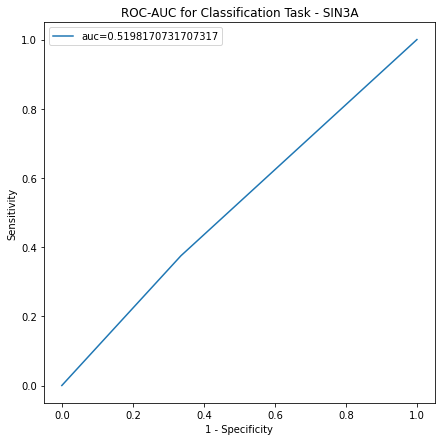

================  NFYB  ================
0.07763525540117673
[[233 118]
 [ 31  18]]
              precision    recall  f1-score   support

           0       0.88      0.66      0.76       351
           1       0.13      0.37      0.19        49

    accuracy                           0.63       400
   macro avg       0.51      0.52      0.48       400
weighted avg       0.79      0.63      0.69       400

=== Statistics ===
Test Accuracy: 0.627
Test Sensitivity: 0.367
Test Specificity: 0.664
Test F1-Score: 0.195
<class 'dict'>
{'accuracy': 0.6275, 'sensitivity': 0.3673469387755102, 'specificity': 0.6638176638176638, 'f1score': 0.1945945945945946}


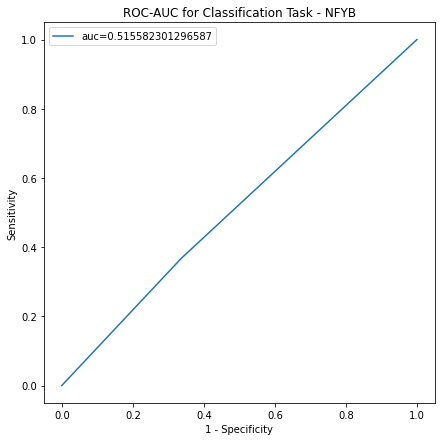

================  NFIC  ================
0.19800174589162184
[[185  76]
 [ 92  47]]
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       261
           1       0.38      0.34      0.36       139

    accuracy                           0.58       400
   macro avg       0.52      0.52      0.52       400
weighted avg       0.57      0.58      0.57       400

=== Statistics ===
Test Accuracy: 0.580
Test Sensitivity: 0.338
Test Specificity: 0.709
Test F1-Score: 0.359
<class 'dict'>
{'accuracy': 0.58, 'sensitivity': 0.3381294964028777, 'specificity': 0.7088122605363985, 'f1score': 0.35877862595419846}


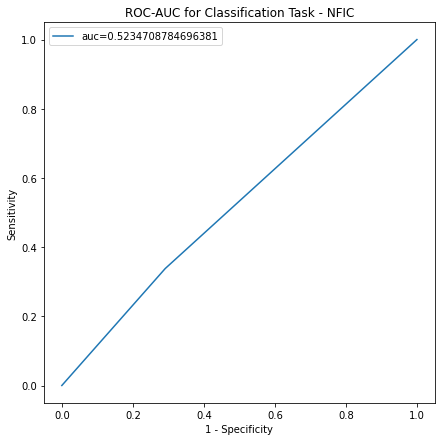

================  PAX5  ================
0.07600269023385478
[[ 74  46]
 [156 124]]
              precision    recall  f1-score   support

           0       0.32      0.62      0.42       120
           1       0.73      0.44      0.55       280

    accuracy                           0.49       400
   macro avg       0.53      0.53      0.49       400
weighted avg       0.61      0.49      0.51       400

=== Statistics ===
Test Accuracy: 0.495
Test Sensitivity: 0.443
Test Specificity: 0.617
Test F1-Score: 0.551
<class 'dict'>
{'accuracy': 0.495, 'sensitivity': 0.44285714285714284, 'specificity': 0.6166666666666667, 'f1score': 0.5511111111111111}


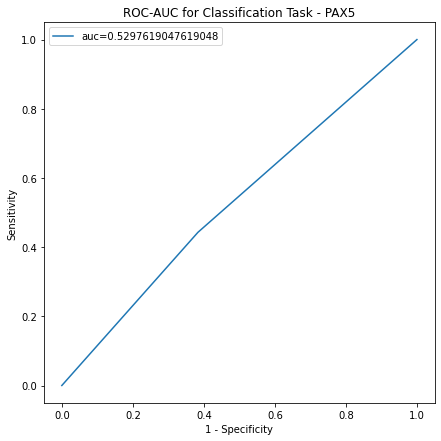

================  NFATC1  ================
0.08752261978017248
[[208  94]
 [ 71  27]]
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       302
           1       0.22      0.28      0.25        98

    accuracy                           0.59       400
   macro avg       0.48      0.48      0.48       400
weighted avg       0.62      0.59      0.60       400

=== Statistics ===
Test Accuracy: 0.588
Test Sensitivity: 0.276
Test Specificity: 0.689
Test F1-Score: 0.247
<class 'dict'>
{'accuracy': 0.5875, 'sensitivity': 0.2755102040816326, 'specificity': 0.6887417218543046, 'f1score': 0.2465753424657534}


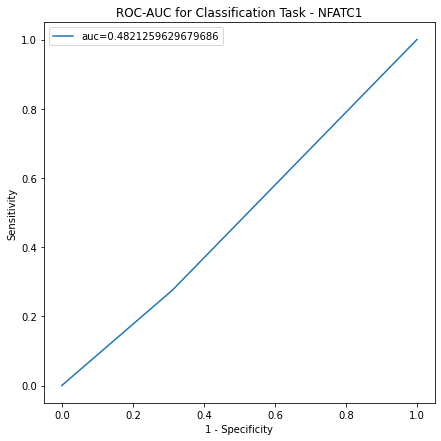

================  SPI1  ================
0.06717903019467808
[[117  75]
 [137  71]]
              precision    recall  f1-score   support

           0       0.46      0.61      0.52       192
           1       0.49      0.34      0.40       208

    accuracy                           0.47       400
   macro avg       0.47      0.48      0.46       400
weighted avg       0.47      0.47      0.46       400

=== Statistics ===
Test Accuracy: 0.470
Test Sensitivity: 0.341
Test Specificity: 0.609
Test F1-Score: 0.401
<class 'dict'>
{'accuracy': 0.47, 'sensitivity': 0.34134615384615385, 'specificity': 0.609375, 'f1score': 0.4011299435028249}


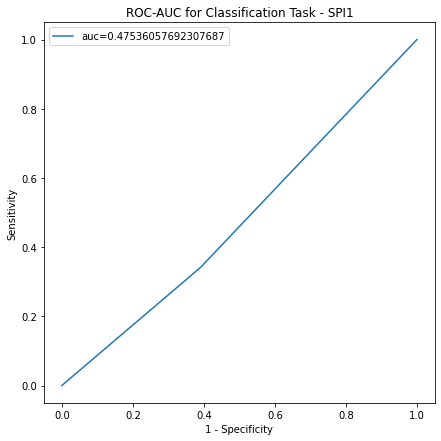

================  USF2  ================
0.11367962479640495
[[128  71]
 [131  70]]
              precision    recall  f1-score   support

           0       0.49      0.64      0.56       199
           1       0.50      0.35      0.41       201

    accuracy                           0.49       400
   macro avg       0.50      0.50      0.48       400
weighted avg       0.50      0.49      0.48       400

=== Statistics ===
Test Accuracy: 0.495
Test Sensitivity: 0.348
Test Specificity: 0.643
Test F1-Score: 0.409
<class 'dict'>
{'accuracy': 0.495, 'sensitivity': 0.3482587064676617, 'specificity': 0.6432160804020101, 'f1score': 0.4093567251461988}


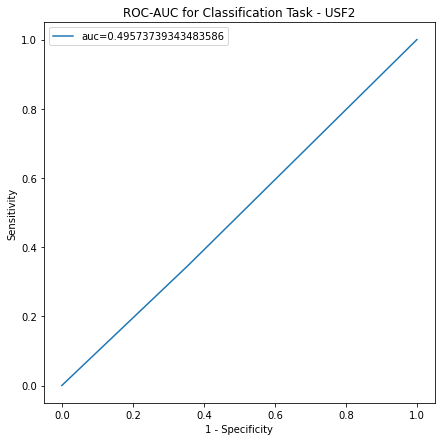

================  ZEB1  ================
0.15681231441263244
[[170  95]
 [ 87  48]]
              precision    recall  f1-score   support

           0       0.66      0.64      0.65       265
           1       0.34      0.36      0.35       135

    accuracy                           0.55       400
   macro avg       0.50      0.50      0.50       400
weighted avg       0.55      0.55      0.55       400

=== Statistics ===
Test Accuracy: 0.545
Test Sensitivity: 0.356
Test Specificity: 0.642
Test F1-Score: 0.345
<class 'dict'>
{'accuracy': 0.545, 'sensitivity': 0.35555555555555557, 'specificity': 0.6415094339622641, 'f1score': 0.34532374100719426}


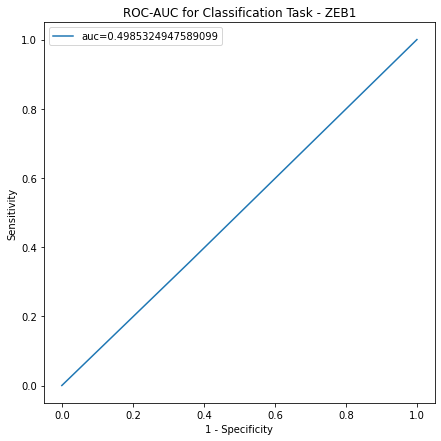

================  USF1  ================
0.041209890481122634
[[171 142]
 [ 54  33]]
              precision    recall  f1-score   support

           0       0.76      0.55      0.64       313
           1       0.19      0.38      0.25        87

    accuracy                           0.51       400
   macro avg       0.47      0.46      0.44       400
weighted avg       0.64      0.51      0.55       400

=== Statistics ===
Test Accuracy: 0.510
Test Sensitivity: 0.379
Test Specificity: 0.546
Test F1-Score: 0.252
<class 'dict'>
{'accuracy': 0.51, 'sensitivity': 0.3793103448275862, 'specificity': 0.5463258785942492, 'f1score': 0.25190839694656486}


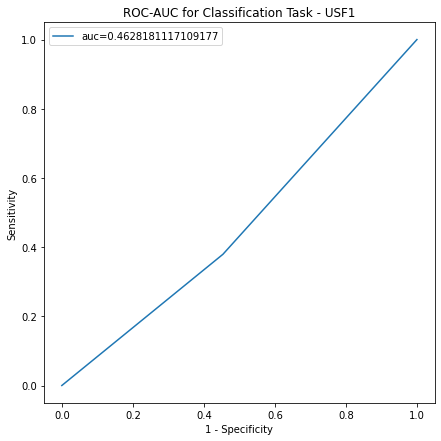

================  TCF3  ================
0.09816755894182289
[[133  89]
 [121  57]]
              precision    recall  f1-score   support

           0       0.52      0.60      0.56       222
           1       0.39      0.32      0.35       178

    accuracy                           0.48       400
   macro avg       0.46      0.46      0.46       400
weighted avg       0.46      0.47      0.47       400

=== Statistics ===
Test Accuracy: 0.475
Test Sensitivity: 0.320
Test Specificity: 0.599
Test F1-Score: 0.352
<class 'dict'>
{'accuracy': 0.475, 'sensitivity': 0.3202247191011236, 'specificity': 0.5990990990990991, 'f1score': 0.35185185185185186}


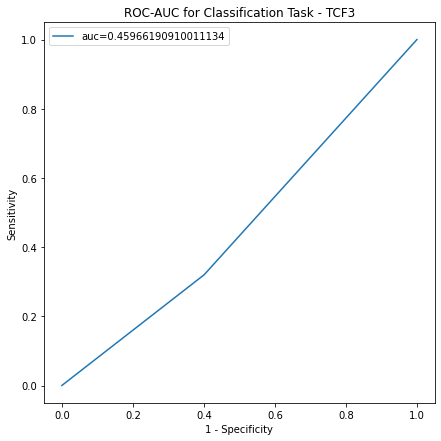

================  ZNF143  ================
0.03500987661172933
[[223 118]
 [ 41  18]]
              precision    recall  f1-score   support

           0       0.84      0.65      0.74       341
           1       0.13      0.31      0.18        59

    accuracy                           0.60       400
   macro avg       0.49      0.48      0.46       400
weighted avg       0.74      0.60      0.66       400

=== Statistics ===
Test Accuracy: 0.603
Test Sensitivity: 0.305
Test Specificity: 0.654
Test F1-Score: 0.185
<class 'dict'>
{'accuracy': 0.6025, 'sensitivity': 0.3050847457627119, 'specificity': 0.6539589442815249, 'f1score': 0.18461538461538463}


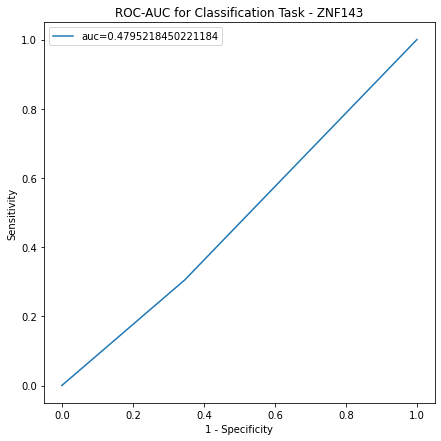

================  YY1  ================
0.041086971521744724
[[161 106]
 [ 81  52]]
              precision    recall  f1-score   support

           0       0.67      0.60      0.63       267
           1       0.33      0.39      0.36       133

    accuracy                           0.53       400
   macro avg       0.50      0.50      0.50       400
weighted avg       0.55      0.53      0.54       400

=== Statistics ===
Test Accuracy: 0.532
Test Sensitivity: 0.391
Test Specificity: 0.603
Test F1-Score: 0.357
<class 'dict'>
{'accuracy': 0.5325, 'sensitivity': 0.39097744360902253, 'specificity': 0.602996254681648, 'f1score': 0.35738831615120276}


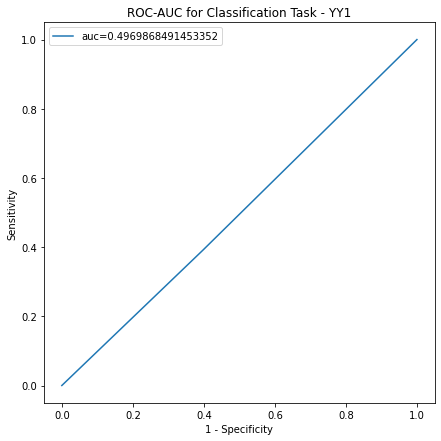

In [45]:
stat_file = open("statistics.txt", "w")
stat_file.write("TF Name\tAccuracy\tSensitivity\tSpecificity\tF1 Score\n")
stat_file.flush()
for i in range(len(tf_list)):
  tf = tf_list[i]
  print("================ ", tf, " ================")
  binding_threshold = np.average(binding_dict[tf])
  print(binding_threshold)
  y_pred_binary = (y_pred[:, i] > binding_threshold) * 1
  y_true_binary = (y_true[:, i] > binding_threshold) * 1
  #print(y_true_binary)
  statistics = classification_statistics(y_true_binary, y_pred_binary)
  #print(type(statistics))
  #print(statistics)
  stat_file.write(tf + "\t" + str(statistics['accuracy']) + "\t" + str(statistics['sensitivity']) + "\t" + str(statistics['specificity']) + "\t" + str(statistics['f1score']) + "\n")
  stat_file.flush()
  roc_auc_curve_plot(y_true_binary,  y_pred_binary, tf)
stat_file.close()